In [1]:
# Clone the repository
!git clone https://github.com/miladmozafari/SpykeTorch

Cloning into 'SpykeTorch'...
remote: Enumerating objects: 1026, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 1026 (delta 9), reused 24 (delta 7), pack-reused 998
Receiving objects: 100% (1026/1026), 6.11 MiB | 4.80 MiB/s, done.
Resolving deltas: 100% (91/91), done.


In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import wave
import pylab
import random
import torchvision
import glob
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.nn.parameter import Parameter
from scipy import signal
from scipy.io import wavfile
from pathlib import Path
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from sklearn import datasets
from SpykeTorch.SpykeTorch import snn
from SpykeTorch.SpykeTorch import functional as sf
from SpykeTorch.SpykeTorch import visualization as vis
from SpykeTorch.SpykeTorch import utils

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
use_cuda = True

In [4]:
!nvidia-smi

Mon Aug 28 21:42:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [31]:
class DigitsSpykeTorch(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = snn.Convolution(6, 30, 5, 0.8, 0.05)
        self.conv1_t = 15
        self.k1 = 5
        self.r1 = 3
        
        self.conv2 = snn.Convolution(30, 250, 3, 0.8, 0.05)
        self.conv2_t = 10
        self.k2 = 8
        self.r2 = 1
        
        self.conv3 = snn.Convolution(250, 200, 5, 0.8, 0.05)
        
        self.stdp1 = snn.STDP(self.conv1, (0.004, -0.003))
        self.stdp2 = snn.STDP(self.conv2, (0.004, -0.003))
        self.stdp3 = snn.STDP(self.conv3, (0.004, -0.003), False, 0.2, 0.8)
        self.anti_stdp3 = snn.STDP(self.conv3, (-0.004, 0.0005), False, 0.2, 0.8)
        self.max_ap = Parameter(torch.Tensor([0.15]))
        
        self.decision_map = []
        for i in range(10):
            self.decision_map.extend([i]*20)

            
        self.ctx = {"input_spikes":None, "potentials":None, "output_spikes":None, "winners":None}
        self.spk_cnt1 = 0
        self.spk_cnt2 = 0

    def forward(self, input, max_layer):
        input = sf.pad(input.float(), (2,2,2,2), 0)
        if self.training:
            pot = self.conv1(input)
            spk, pot = sf.fire(pot, self.conv1_t, True)
            if max_layer == 1:
                self.spk_cnt1 += 1
                if self.spk_cnt1 >= 500:
                    self.spk_cnt1 = 0
                    ap = torch.tensor(self.stdp1.learning_rate[0][0].item(), device=self.stdp1.learning_rate[0][0].device) * 2
                    ap = torch.min(ap, self.max_ap)
                    an = ap * -0.75
                    self.stdp1.update_all_learning_rate(ap.item(), an.item())
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k1, self.r1, spk)
                self.ctx["input_spikes"] = input
                self.ctx["potentials"] = pot
                self.ctx["output_spikes"] = spk
                self.ctx["winners"] = winners
                return spk, pot
            spk_in = sf.pad(sf.pooling(spk, 2, 2), (1,1,1,1))
            pot = self.conv2(spk_in)
            spk, pot = sf.fire(pot, self.conv2_t, True)
            if max_layer == 2:
                self.spk_cnt2 += 1
                if self.spk_cnt2 >= 500:
                    self.spk_cnt2 = 0
                    ap = torch.tensor(self.stdp2.learning_rate[0][0].item(), device=self.stdp2.learning_rate[0][0].device) * 2
                    ap = torch.min(ap, self.max_ap)
                    an = ap * -0.75
                    self.stdp2.update_all_learning_rate(ap.item(), an.item())
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k2, self.r2, spk)
                self.ctx["input_spikes"] = spk_in
                self.ctx["potentials"] = pot
                self.ctx["output_spikes"] = spk
                self.ctx["winners"] = winners
                return spk, pot
            spk_in = sf.pad(sf.pooling(spk, 3, 3), (2,2,2,2))
            pot = self.conv3(spk_in)
            spk = sf.fire(pot)
            winners = sf.get_k_winners(pot, 1, 0, spk)
            self.ctx["input_spikes"] = spk_in
            self.ctx["potentials"] = pot
            self.ctx["output_spikes"] = spk
            self.ctx["winners"] = winners
            output = -1
            if len(winners) != 0:
                output = self.decision_map[winners[0][0]]
            return output
        else:
            pot = self.conv1(input)
            spk, pot = sf.fire(pot, self.conv1_t, True)
            if max_layer == 1:
                return spk, pot
            pot = self.conv2(sf.pad(sf.pooling(spk, 2, 2), (1,1,1,1)))
            spk, pot = sf.fire(pot, self.conv2_t, True)
            if max_layer == 2:
                return spk, pot
            pot = self.conv3(sf.pad(sf.pooling(spk, 3, 3), (2,2,2,2)))
            spk = sf.fire(pot)
            winners = sf.get_k_winners(pot, 1, 0, spk)
            output = -1
            if len(winners) != 0:
                output = self.decision_map[winners[0][0]]
            return output
        
    def stdp(self, layer_idx):
        if layer_idx == 1:
            self.stdp1(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])
        if layer_idx == 2:
            self.stdp2(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])
            
    def update_learning_rates(self, stdp_ap, stdp_an, anti_stdp_ap, anti_stdp_an):
        self.stdp3.update_all_learning_rate(stdp_ap, stdp_an)
        self.anti_stdp3.update_all_learning_rate(anti_stdp_an, anti_stdp_ap)
        
    def reward(self):
        self.stdp3(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])

    def punish(self):
        self.anti_stdp3(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])

In [6]:
def train_unsupervise(network, data, layer_idx):
    network.train()
    for i in range(len(data)):
        data_in = data[i]
        if use_cuda:
            data_in = data_in.cuda()
        network(data_in, layer_idx)
        network.stdp(layer_idx)

In [7]:
def train_rl(network, data, target):
    network.train()
    perf = np.array([0,0,0]) # correct, wrong, silence
    for i in range(len(data)):
        data_in = data[i]
        target_in = target[i]
        if use_cuda:
            data_in = data_in.cuda()
            target_in = target_in.cuda()
        d = network(data_in, 3)
        if d != -1:
            if d == target_in:
                perf[0]+=1
                network.reward()
            else:
                perf[1]+=1
                network.punish()
        else:
            perf[2]+=1
    return perf/len(data)

In [8]:
def test(network, data, target):
    network.eval()
    perf = np.array([0,0,0]) # correct, wrong, silence
    for i in range(len(data)):
        data_in = data[i]
        target_in = target[i]
        if use_cuda:
            data_in = data_in.cuda()
            target_in = target_in.cuda()
        d = network(data_in, 3)
        if d != -1:
            if d == target_in:
                perf[0]+=1
            else:
                perf[1]+=1
        else:
            perf[2]+=1
    return perf/len(data)

In [9]:
class S1C1Transform:
    def __init__(self, filter, timesteps = 15):
        self.gray_scale = transforms.Grayscale()
        self.to_tensor = transforms.ToTensor()
        self.filter = filter
        self.temporal_transform = utils.Intensity2Latency(timesteps)
        self.cnt = 0
        
    def __call__(self, image):
        if self.cnt % 1000 == 0:
            print(self.cnt)
        self.cnt+=1
        image = self.to_tensor(image) * 255
        image = image.type(torch.float32)
        image = self.gray_scale(image)
        image.unsqueeze_(0)
        image = self.filter(image)
        image = sf.local_normalization(image, 8)
        temporal_image = self.temporal_transform(image)
        return temporal_image.sign().byte()

In [33]:
kernels = [ utils.DoGKernel(3,6/64,3/64),
            utils.DoGKernel(3,5/64,2/64),
            utils.DoGKernel(2,8/64,4/64),
            utils.DoGKernel(2,7/64,3/64),
            utils.DoGKernel(3,8/64,4/64),
            utils.DoGKernel(3,7/64,3/64),
            ]

In [34]:
filter = utils.Filter(kernels, padding = 6, thresholds = 80)
s1c1 = S1C1Transform(filter)

In [13]:
digits = datasets.load_digits()

In [14]:
# Create features
img_data = digits.data

# Create target
labels = digits.target

imgs = digits.images

In [15]:
output_dir = "digits_images"
os.makedirs(output_dir, exist_ok=True)

for label in range(10):
    os.makedirs(f"digits_images/class_{label}", exist_ok=True)

In [16]:
# function to load images from sklearn dataset "digits" to folder  
def save_digits(img_data, labels, digit_dir="/kaggle/working/digits_images"):
    digit_path = Path(digit_dir)
    for idx, (image_data, label) in tqdm(enumerate(zip(img_data, labels)), total=len(img_data), desc="Converting"):
        image = Image.fromarray(image_data.astype(np.uint8) * 16)
        output_dir = digit_path / f"class_{label}"
        image_filename = os.path.join(output_dir, f"digit_{idx}_{label}.png")
        if not os.path.exists(image_filename):
            image.save(image_filename)

In [17]:
save_digits(imgs, labels)

Converting: 100%|██████████| 1797/1797 [00:00<00:00, 3390.38it/s]


In [18]:
for dirpath, dirnames, filenames in os.walk("/kaggle/working/digits_images/"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 10 directories and 0 images in '/kaggle/working/digits_images/'.
There are 0 directories and 182 images in '/kaggle/working/digits_images/class_5'.
There are 0 directories and 181 images in '/kaggle/working/digits_images/class_4'.
There are 0 directories and 183 images in '/kaggle/working/digits_images/class_3'.
There are 0 directories and 174 images in '/kaggle/working/digits_images/class_8'.
There are 0 directories and 182 images in '/kaggle/working/digits_images/class_1'.
There are 0 directories and 179 images in '/kaggle/working/digits_images/class_7'.
There are 0 directories and 178 images in '/kaggle/working/digits_images/class_0'.
There are 0 directories and 177 images in '/kaggle/working/digits_images/class_2'.
There are 0 directories and 180 images in '/kaggle/working/digits_images/class_9'.
There are 0 directories and 181 images in '/kaggle/working/digits_images/class_6'.


In [35]:
dataset = ImageFolder("/kaggle/working/digits_images/", s1c1)

In [20]:
# splitting training and testing sets
indices = list(range(len(labels)))
random.shuffle(indices)
split_point = int(0.75*len(indices))
train_indices = indices[:split_point]
test_indices = indices[split_point:]
print("Size of the training set:", len(train_indices))
print("Size of the  testing set:", len(test_indices))

Size of the training set: 1347
Size of the  testing set: 450


In [36]:
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler

dataset = utils.CacheDataset(dataset)
train_loader = DataLoader(dataset, sampler=SubsetRandomSampler(train_indices))
test_loader = DataLoader(dataset, sampler=SubsetRandomSampler(test_indices))

/tmp/ipykernel_29/510297376.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


0


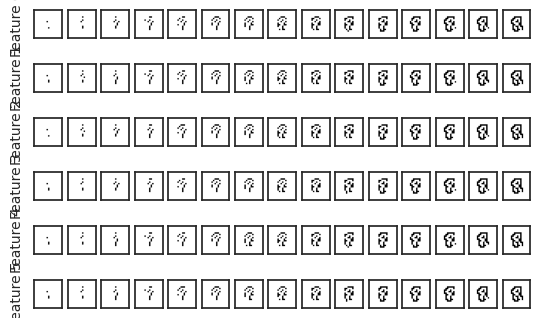

In [37]:
sample_idx = random.randint(0, len(dataset) - 1)

plt.style.use('seaborn-white')
plt_idx = 0
sw = dataset[sample_idx][0]

for f in range(6):
    for t in range(15):
        plt_idx += 1
        ax = plt.subplot(7, 15, plt_idx)
        plt.setp(ax, xticklabels=[])
        plt.setp(ax, yticklabels=[])
        if t == 0:
            ax.set_ylabel('Feature ' + str(f))
        plt.imshow(sw[t,f])
        if f == 6:
            ax = plt.subplot(7, 15, plt_idx + 15)
            plt.setp(ax, xticklabels=[])
            plt.setp(ax, yticklabels=[])
            if t == 0:
                ax.set_ylabel('Sum')
            ax.set_xlabel('t = ' + str(t))
            plt.imshow(sw[t].sum(dim=0).numpy())
plt.show()

In [39]:
net = DigitsSpykeTorch()

if use_cuda:
    net.cuda()

In [40]:
# Training The First Layer
print("Training the first layer")
if os.path.isfile("/kaggle/input/digits_saved/saved_l1.net"):
    net.load_state_dict(torch.load("/kaggle/input/digits_saved/saved_l1.net"))
else:
    for epoch in range(3):
        print("Epoch", epoch)
        iter = 0
        for data,targets in train_loader:
            print("Iteration", iter)
            train_unsupervise(net, data, 1)
            print("Done!")
            iter+=1
    torch.save(net.state_dict(), "saved_l1.net")

Training the first layer
Epoch 0
Iteration 0
Done!
Iteration 1
Done!
Iteration 2
Done!
Iteration 3
Done!
Iteration 4
Done!
Iteration 5
Done!
Iteration 6
Done!
Iteration 7
Done!
Iteration 8
Done!
Iteration 9
Done!
Iteration 10
Done!
Iteration 11
Done!
Iteration 12
Done!
Iteration 13
Done!
Iteration 14
Done!
Iteration 15
Done!
Iteration 16
Done!
Iteration 17
Done!
Iteration 18
Done!
Iteration 19
Done!
Iteration 20
Done!
Iteration 21
Done!
Iteration 22
Done!
Iteration 23
Done!
Iteration 24
Done!
Iteration 25
Done!
Iteration 26
Done!
Iteration 27
Done!
Iteration 28
Done!
Iteration 29
Done!
Iteration 30
Done!
Iteration 31
Done!
Iteration 32
Done!
Iteration 33
Done!
Iteration 34
Done!
Iteration 35
Done!
Iteration 36
Done!
Iteration 37
Done!
Iteration 38
Done!
Iteration 39
Done!
Iteration 40
Done!
Iteration 41
Done!
Iteration 42
Done!
Iteration 43
Done!
Iteration 44
Done!
Iteration 45
Done!
Iteration 46
Done!
Iteration 47
Done!
Iteration 48
Done!
Iteration 49
Done!
Iteration 50
Done!
Iteratio

In [41]:
# Training The Second Layer
print("Training the second layer")
if os.path.isfile("/kaggle/input/digits_saved/saved_l2.net"):
    net.load_state_dict(torch.load("/kaggle/input/digits_saved/saved_l2.net"))
else:
    for epoch in range(5):
        print("Epoch", epoch)
        iter = 0
        for data,targets in train_loader:
            print("Iteration", iter)
            train_unsupervise(net, data, 2)
            print("Done!")
            iter+=1
    torch.save(net.state_dict(), "saved_l2.net")

Training the second layer
Epoch 0
Iteration 0
Done!
Iteration 1
Done!
Iteration 2
Done!
Iteration 3
Done!
Iteration 4
Done!
Iteration 5
Done!
Iteration 6
Done!
Iteration 7
Done!
Iteration 8
Done!
Iteration 9
Done!
Iteration 10
Done!
Iteration 11
Done!
Iteration 12
Done!
Iteration 13
Done!
Iteration 14
Done!
Iteration 15
Done!
Iteration 16
Done!
Iteration 17
Done!
Iteration 18
Done!
Iteration 19
Done!
Iteration 20
Done!
Iteration 21
Done!
Iteration 22
Done!
Iteration 23
Done!
Iteration 24
Done!
Iteration 25
Done!
Iteration 26
Done!
Iteration 27
Done!
Iteration 28
Done!
Iteration 29
Done!
Iteration 30
Done!
Iteration 31
Done!
Iteration 32
Done!
Iteration 33
Done!
Iteration 34
Done!
Iteration 35
Done!
Iteration 36
Done!
Iteration 37
Done!
Iteration 38
Done!
Iteration 39
Done!
Iteration 40
Done!
Iteration 41
Done!
Iteration 42
Done!
Iteration 43
Done!
Iteration 44
Done!
Iteration 45
Done!
Iteration 46
Done!
Iteration 47
Done!
Iteration 48
Done!
Iteration 49
Done!
Iteration 50
Done!
Iterati

In [42]:
# initial adaptive learning rates
apr = net.stdp3.learning_rate[0][0].item()
anr = net.stdp3.learning_rate[0][1].item()
app = net.anti_stdp3.learning_rate[0][1].item()
anp = net.anti_stdp3.learning_rate[0][0].item()

adaptive_min = 0
adaptive_int = 1
apr_adapt = ((1.0 - 1.0 / 10) * adaptive_int + adaptive_min) * apr
anr_adapt = ((1.0 - 1.0 / 10) * adaptive_int + adaptive_min) * anr
app_adapt = ((1.0 / 10) * adaptive_int + adaptive_min) * app
anp_adapt = ((1.0 / 10) * adaptive_int + adaptive_min) * anp

In [43]:
# perf
best_train = np.array([0.0,0.0,0.0,0.0]) # correct, wrong, silence, epoch
best_test = np.array([0.0,0.0,0.0,0.0]) # correct, wrong, silence, epoch

In [29]:
if os.path.isfile("/kaggle/input/digits_saved/saved.net"):
    net.load_state_dict(torch.load("/kaggle/input/digits_saved/saved.net"))

In [53]:
# Training The Third Layer
print("Training the third layer")
for epoch in tqdm(range(20)):
    print("Epoch #:", epoch)
    perf_train = np.array([0.0,0.0,0.0])
    perf_test = np.array([0.0,0.0,0.0])
    for data,targets in train_loader:
        perf_train_batch = train_rl(net, data, targets)
#         print(perf_train_batch)
        #update adaptive learning rates
        apr_adapt = apr * (perf_train_batch[1] * adaptive_int + adaptive_min)
        anr_adapt = anr * (perf_train_batch[1] * adaptive_int + adaptive_min)
        app_adapt = app * (perf_train_batch[0] * adaptive_int + adaptive_min)
        anp_adapt = anp * (perf_train_batch[0] * adaptive_int + adaptive_min)
        net.update_learning_rates(apr_adapt, anr_adapt, app_adapt, anp_adapt)
        perf_train += perf_train_batch
    perf_train /= len(train_loader)
    if best_train[0] <= perf_train[0]:
        best_train = np.append(perf_train, epoch)
    print("Current Train:", perf_train)
    print("   Best Train:", best_train)

    for data,targets in test_loader:
        perf_test += test(net, data, targets)
    perf_test /= len(test_loader)
    if best_test[0] <= perf_test[0]:
        best_test = np.append(perf_test, epoch)
        torch.save(net.state_dict(), "saved.net")
    print(" Current Test:", perf_test)
#     print("    Best Test:", best_test)

Training the third layer


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch #: 0
Current Train: [0.87305122 0.12694878 0.        ]
   Best Train: [ 0.88195991  0.11804009  0.         14.        ]


  5%|▌         | 1/20 [00:21<06:52, 21.70s/it]

 Current Test: [0.60222222 0.39777778 0.        ]
Epoch #: 1
Current Train: [0.87305122 0.12694878 0.        ]
   Best Train: [ 0.88195991  0.11804009  0.         14.        ]


 10%|█         | 2/20 [00:43<06:33, 21.86s/it]

 Current Test: [0.60222222 0.39777778 0.        ]
Epoch #: 2
Current Train: [0.88047513 0.11952487 0.        ]
   Best Train: [ 0.88195991  0.11804009  0.         14.        ]


 15%|█▌        | 3/20 [01:05<06:11, 21.85s/it]

 Current Test: [0.58888889 0.41111111 0.        ]
Epoch #: 3
Current Train: [0.88047513 0.11952487 0.        ]
   Best Train: [ 0.88195991  0.11804009  0.         14.        ]


 20%|██        | 4/20 [01:26<05:46, 21.64s/it]

 Current Test: [0.60222222 0.39777778 0.        ]
Epoch #: 4
Current Train: [0.88047513 0.11952487 0.        ]
   Best Train: [ 0.88195991  0.11804009  0.         14.        ]


 25%|██▌       | 5/20 [01:48<05:26, 21.78s/it]

 Current Test: [0.57555556 0.42444444 0.        ]
Epoch #: 5
Current Train: [0.88195991 0.11804009 0.        ]
   Best Train: [0.88195991 0.11804009 0.         5.        ]


 30%|███       | 6/20 [02:10<05:05, 21.80s/it]

 Current Test: [0.58222222 0.41777778 0.        ]
Epoch #: 6
Current Train: [0.87750557 0.12249443 0.        ]
   Best Train: [0.88195991 0.11804009 0.         5.        ]


 35%|███▌      | 7/20 [02:32<04:44, 21.86s/it]

 Current Test: [0.59111111 0.40888889 0.        ]
Epoch #: 7
Current Train: [0.87899035 0.12100965 0.        ]
   Best Train: [0.88195991 0.11804009 0.         5.        ]


 40%|████      | 8/20 [02:54<04:21, 21.76s/it]

 Current Test: [0.60666667 0.39333333 0.        ]
Epoch #: 8
Current Train: [0.88492947 0.11507053 0.        ]
   Best Train: [0.88492947 0.11507053 0.         8.        ]


 45%|████▌     | 9/20 [03:16<04:00, 21.87s/it]

 Current Test: [0.58 0.42 0.  ]
Epoch #: 9
Current Train: [0.88047513 0.11952487 0.        ]
   Best Train: [0.88492947 0.11507053 0.         8.        ]


 50%|█████     | 10/20 [03:38<03:39, 21.96s/it]

 Current Test: [0.58444444 0.41555556 0.        ]
Epoch #: 10
Current Train: [0.88492947 0.11507053 0.        ]
   Best Train: [ 0.88492947  0.11507053  0.         10.        ]


 55%|█████▌    | 11/20 [04:00<03:16, 21.84s/it]

 Current Test: [0.57555556 0.42444444 0.        ]
Epoch #: 11
Current Train: [0.87602079 0.12397921 0.        ]
   Best Train: [ 0.88492947  0.11507053  0.         10.        ]


 60%|██████    | 12/20 [04:22<02:55, 21.89s/it]

 Current Test: [0.58666667 0.41333333 0.        ]
Epoch #: 12
Current Train: [0.87899035 0.12100965 0.        ]
   Best Train: [ 0.88492947  0.11507053  0.         10.        ]


 65%|██████▌   | 13/20 [04:44<02:34, 22.01s/it]

 Current Test: [0.59111111 0.40888889 0.        ]
Epoch #: 13
Current Train: [0.88715664 0.11284336 0.        ]
   Best Train: [ 0.88715664  0.11284336  0.         13.        ]


 70%|███████   | 14/20 [05:05<02:11, 21.86s/it]

 Current Test: [0.58444444 0.41555556 0.        ]
Epoch #: 14
Current Train: [0.88047513 0.11952487 0.        ]
   Best Train: [ 0.88715664  0.11284336  0.         13.        ]


 75%|███████▌  | 15/20 [05:27<01:49, 21.92s/it]

 Current Test: [0.59555556 0.40444444 0.        ]
Epoch #: 15
Current Train: [0.87453601 0.12546399 0.        ]
   Best Train: [ 0.88715664  0.11284336  0.         13.        ]


 80%|████████  | 16/20 [05:49<01:27, 21.90s/it]

 Current Test: [0.58 0.42 0.  ]
Epoch #: 16
Current Train: [0.88047513 0.11952487 0.        ]
   Best Train: [ 0.88715664  0.11284336  0.         13.        ]


 85%|████████▌ | 17/20 [06:11<01:05, 21.76s/it]

 Current Test: [0.56888889 0.43111111 0.        ]
Epoch #: 17
Current Train: [0.88047513 0.11952487 0.        ]
   Best Train: [ 0.88715664  0.11284336  0.         13.        ]


 90%|█████████ | 18/20 [06:32<00:43, 21.76s/it]

 Current Test: [0.60888889 0.39111111 0.        ]
Epoch #: 18
Current Train: [0.8827023 0.1172977 0.       ]
   Best Train: [ 0.88715664  0.11284336  0.         13.        ]


 95%|█████████▌| 19/20 [06:54<00:21, 21.79s/it]

 Current Test: [0.61333333 0.38666667 0.        ]
Epoch #: 19
Current Train: [0.88047513 0.11952487 0.        ]
   Best Train: [ 0.88715664  0.11284336  0.         13.        ]


100%|██████████| 20/20 [07:16<00:00, 21.82s/it]

 Current Test: [0.58 0.42 0.  ]
